In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import time

tempoInicial = time.time()

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psix(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    Pxt = N(n)*Hn(x)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [3]:
def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 2000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = np.pi
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psix(0, xs) + 0.60 * psix(1, xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [4]:
def multMatrizes(M, us, ps, O = 0, L = 1, T = 0.5):
    N = 2000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = np.pi
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*(w+us)**2*xs**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()

    b = np.matmul(matrizB, np.array(ps)) #Multiplicação de arrays já que houve uma conversão anterior
    psi_c = np.linalg.solve(matrizA, b) #Matlab: x = A\b
    #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return psi_c

In [5]:
# Gradiente e função objetivo

def ExactSolution(M, T = 5, L = 5):
    N = 2000

    xs = np.linspace(-5, L, M)
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.05):
        for j in np.arange(0, 20, 0.01):
            psiExato[r][int(j*100)] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    return psiExato

def Objetivo(x, y, psii, psiExato):
    A = multMatrizes(M = 200, us = x[0], ps = psii[0:200, y], O = -5, L = 5, T = 20)
    B = multMatrizes(M = 200, us = x[1], ps = A, O = -5, L = 5, T = 20)
    C = multMatrizes(M = 200, us = x[2], ps = B, O = -5, L = 5, T = 20)
    D = multMatrizes(M = 200, us = x[3], ps = C, O = -5, L = 5, T = 20)
    E = multMatrizes(M = 200, us = x[4], ps = D, O = -5, L = 5, T = 20)
    F = multMatrizes(M = 200, us = x[5], ps = E, O = -5, L = 5, T = 20)
    G = multMatrizes(M = 200, us = x[6], ps = F, O = -5, L = 5, T = 20)
    H = multMatrizes(M = 200, us = x[7], ps = G, O = -5, L = 5, T = 20)
    I = multMatrizes(M = 200, us = x[8], ps = H, O = -5, L = 5, T = 20)
    J = multMatrizes(M = 200, us = x[9], ps = I, O = -5, L = 5, T = 20)
    K = multMatrizes(M = 200, us = x[10], ps = J, O = -5, L = 5, T = 20)
        
    return ((np.linalg.norm(np.array(psiExato[0:200, y])-np.array(psii[0:200, y])))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+1])-np.array(A)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+2])-np.array(B)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+3])-np.array(C)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+4])-np.array(D)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+5])-np.array(E)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+6])-np.array(F)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+7])-np.array(G)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+8])-np.array(H)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+9])-np.array(I)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+10])-np.array(J)))**2+
            (np.linalg.norm(np.array(psiExato[0:200, y+11])-np.array(K)))**2)

In [6]:
import random

psi = np.zeros((200,2000))
psi_f = np.zeros((200,2000))
psi_g = psi_f.astype(complex)
psi = CrankNicolson(M = 200, O = -5, L = 5, T = 20)
psi_g = CrankNicolson(M = 200, O = -5, L = 5, T = 20)
psiExato = ExactSolution(M = 200)

In [7]:
xs = np.linspace(-5,5,200)

Iteração: 1
Mínimo: -0.3141592653589793
Iteração: 2
Mínimo: -0.10894016041834277
Iteração: 3
Mínimo: -0.04030221911968616
Iteração: 4
Mínimo: -0.003577701151747991
Iteração: 5
Mínimo: -0.0010165108003938016
Iteração: 6
Mínimo: -0.00381760404741395
Iteração: 7
Mínimo: -0.005620946093546502
Iteração: 8
Mínimo: -0.006732228823937807
Iteração: 9
Mínimo: -0.007551658895506671
Iteração: 10
Mínimo: -0.008287374650462266
Iteração: 11
Mínimo: -0.008926459554476669
Iteração: 12
Mínimo: -0.009465431982835332
Iteração: 13
Mínimo: -0.01009331470763344
Iteração: 14
Mínimo: -0.010707759852295877
Iteração: 15
Mínimo: -0.011375288044952884
Iteração: 16
Mínimo: 0.002942152886651306
Iteração: 17
Mínimo: -0.004922780643590154
Iteração: 18
Mínimo: -0.014496893172324051
Iteração: 19
Mínimo: 5.469671093017055e-05
Iteração: 20
Mínimo: -0.016294705538186918
Iteração: 21
Mínimo: -0.019987339843133306
Iteração: 22
Mínimo: -0.026064741208042995
Iteração: 23
Mínimo: -0.023807986908000966
Iteração: 24
Mínimo: -0.04

Iteração: 194
Mínimo: -0.027151032702756192
Iteração: 195
Mínimo: -0.04223341553048036
Iteração: 196
Mínimo: -0.028254921379707715
Iteração: 197
Mínimo: -0.04625424863187293
Iteração: 198
Mínimo: -0.0738139020719536
Iteração: 199
Mínimo: -0.08081919521346971
Iteração: 200
Mínimo: -0.058088150749896726
Iteração: 201
Mínimo: -0.02134128071393055
Iteração: 202
Mínimo: 0.058788770293854625
Iteração: 203
Mínimo: 0.3141592653589792
Iteração: 204
Mínimo: 0.31415926535897926
Iteração: 205
Mínimo: -0.3141592653589793
Iteração: 206
Mínimo: 0.20728466365070264
Iteração: 207
Mínimo: -0.3141592653589793
Iteração: 208
Mínimo: -0.3141592653589793
Iteração: 209
Mínimo: -0.3141592653589793
Iteração: 210
Mínimo: -0.21559876398376565
Iteração: 211
Mínimo: -0.032665071429134364
Iteração: 212
Mínimo: -0.03426436195612861
Iteração: 213
Mínimo: -0.03378205219020267
Iteração: 214
Mínimo: -0.03302618329401743
Iteração: 215
Mínimo: -0.03227460231935528
Iteração: 216
Mínimo: -0.03148651057454496
Iteração: 217
Mí

Iteração: 384
Mínimo: -0.04020135777076504
Iteração: 385
Mínimo: -0.04049414080334822
Iteração: 386
Mínimo: -0.04074994571898811
Iteração: 387
Mínimo: -0.040988266385182284
Iteração: 388
Mínimo: -0.041157968340259705
Iteração: 389
Mínimo: -0.04130041712441937
Iteração: 390
Mínimo: -0.041455657181243236
Iteração: 391
Mínimo: -0.04153304986099306
Iteração: 392
Mínimo: -0.041597891984483076
Iteração: 393
Mínimo: -0.04164951053501937
Iteração: 394
Mínimo: -0.04165416814431511
Iteração: 395
Mínimo: -0.04163519581097104
Iteração: 396
Mínimo: -0.041580489370680714
Iteração: 397
Mínimo: -0.041511998993886585
Iteração: 398
Mínimo: -0.04139907688757792
Iteração: 399
Mínimo: -0.022683273052202545
Iteração: 400
Mínimo: -0.02875227982765753
Iteração: 401
Mínimo: -0.03979751320008468
Iteração: 402
Mínimo: -0.04556638010013569
Iteração: 403
Mínimo: -0.0334477601902877
Iteração: 404
Mínimo: -0.059956472481094605
Iteração: 405
Mínimo: -0.05332708878950716
Iteração: 406
Mínimo: -0.03570864301028922
Iter

Iteração: 574
Mínimo: -0.030831132626463722
Iteração: 575
Mínimo: -0.04105875616710611
Iteração: 576
Mínimo: -0.04057190736352952
Iteração: 577
Mínimo: -0.03981853701122491
Iteração: 578
Mínimo: -0.03953619240147005
Iteração: 579
Mínimo: -0.039603778189909955
Iteração: 580
Mínimo: -0.03979057660442062
Iteração: 581
Mínimo: -0.040021078917934945
Iteração: 582
Mínimo: -0.04023338489316443
Iteração: 583
Mínimo: -0.04049952942040704
Iteração: 584
Mínimo: -0.04069227297376651
Iteração: 585
Mínimo: -0.04088760278541558
Iteração: 586
Mínimo: -0.04102694841311652
Iteração: 587
Mínimo: -0.0411898415045908
Iteração: 588
Mínimo: -0.04125256329735898
Iteração: 589
Mínimo: -0.041367873725439167
Iteração: 590
Mínimo: -0.04139966421690633
Iteração: 591
Mínimo: -0.04141042346098703
Iteração: 592
Mínimo: -0.041417228963798305
Iteração: 593
Mínimo: -0.04135614305939542
Iteração: 594
Mínimo: -0.04129153000451799
Iteração: 595
Mínimo: -0.04118653513830932
Iteração: 596
Mínimo: -0.04108961774773845
Iteraçã

Iteração: 764
Mínimo: -0.029689984443893345
Iteração: 765
Mínimo: -0.029689984443893345
Iteração: 766
Mínimo: -0.03149909542495208
Iteração: 767
Mínimo: -0.03149909542495208
Iteração: 768
Mínimo: -0.032027371391596365
Iteração: 769
Mínimo: -0.03398638407835967
Iteração: 770
Mínimo: -0.03380868233986461
Iteração: 771
Mínimo: -0.03380868233986461
Iteração: 772
Mínimo: -0.03440389432259166
Iteração: 773
Mínimo: -0.0427797108908284
Iteração: 774
Mínimo: -0.042651670158725674
Iteração: 775
Mínimo: -0.04104408963349158
Iteração: 776
Mínimo: -0.04029476341172382
Iteração: 777
Mínimo: -0.033007307783235726
Iteração: 778
Mínimo: -0.04339173348923654
Iteração: 779
Mínimo: -0.042919516401265095
Iteração: 780
Mínimo: -0.04204460059660136
Iteração: 781
Mínimo: -0.041768250301487946
Iteração: 782
Mínimo: -0.04176889594194855
Iteração: 783
Mínimo: -0.041943747581020235
Iteração: 784
Mínimo: -0.0421388882405417
Iteração: 785
Mínimo: -0.04231431682700285
Iteração: 786
Mínimo: -0.04248625396903098
Itera

Iteração: 956
Mínimo: -0.060654230550260424
Iteração: 957
Mínimo: -0.03641679280176053
Iteração: 958
Mínimo: -0.026976914052474016
Iteração: 959
Mínimo: -0.020630665039883943
Iteração: 960
Mínimo: -0.023014347198761283
Iteração: 961
Mínimo: -0.023014347198761283
Iteração: 962
Mínimo: -0.023014347198761283
Iteração: 963
Mínimo: -0.025297380371720603
Iteração: 964
Mínimo: -0.025297380371720603
Iteração: 965
Mínimo: -0.025297380371720603
Iteração: 966
Mínimo: -0.027831932928091194
Iteração: 967
Mínimo: -0.012190025813778458
Iteração: 968
Mínimo: -0.025615290536299965
Iteração: 969
Mínimo: -0.02973313512703485
Iteração: 970
Mínimo: -0.03399888031152673
Iteração: 971
Mínimo: -0.039691465862976144
Iteração: 972
Mínimo: -0.03819329932813166
Iteração: 973
Mínimo: -0.07711432876401353
Iteração: 974
Mínimo: -0.029366704610831684
Iteração: 975
Mínimo: 0.05003692209039713
Iteração: 976
Mínimo: 0.3141592653589793
Iteração: 977
Mínimo: 0.3141592653589793
Iteração: 978
Mínimo: -0.3141592653589793
Ite

Iteração: 1143
Mínimo: -0.005932373896614326
Iteração: 1144
Mínimo: -0.009447694143690188
Iteração: 1145
Mínimo: -0.020724471860711368
Iteração: 1146
Mínimo: -0.017254066268448436
Iteração: 1147
Mínimo: -0.018822864609938497
Iteração: 1148
Mínimo: -0.008363755881510391
Iteração: 1149
Mínimo: -0.011881042868511346
Iteração: 1150
Mínimo: -0.024907896214771942
Iteração: 1151
Mínimo: -0.021524450355522445
Iteração: 1152
Mínimo: -0.023049723268693253
Iteração: 1153
Mínimo: -0.023027918786452602
Iteração: 1154
Mínimo: -0.02369190353301127
Iteração: 1155
Mínimo: -0.02421414029292122
Iteração: 1156
Mínimo: -0.02486399527601504
Iteração: 1157
Mínimo: -0.025542862481772042
Iteração: 1158
Mínimo: -0.026263995364742262
Iteração: 1159
Mínimo: -0.027008705812754965
Iteração: 1160
Mínimo: -0.027779677152372003
Iteração: 1161
Mínimo: -0.028550929603780032
Iteração: 1162
Mínimo: -0.02932531413191397
Iteração: 1163
Mínimo: -0.03010239892102215
Iteração: 1164
Mínimo: -0.03087459643067202
Iteração: 1165
M

Iteração: 1329
Mínimo: 0.0023628457503480317
Iteração: 1330
Mínimo: 0.001399304803996102
Iteração: 1331
Mínimo: 0.00045145731675093424
Iteração: 1332
Mínimo: -0.000532045271905186
Iteração: 1333
Mínimo: -0.011492900414327682
Iteração: 1334
Mínimo: -0.0058285029748674855
Iteração: 1335
Mínimo: 0.002935263478748517
Iteração: 1336
Mínimo: -0.0007557134461820998
Iteração: 1337
Mínimo: -0.00378330870837848
Iteração: 1338
Mínimo: -0.015984471903842435
Iteração: 1339
Mínimo: -0.011940821715074563
Iteração: 1340
Mínimo: -0.012712150011837557
Iteração: 1341
Mínimo: -0.0008445269833086185
Iteração: 1342
Mínimo: -0.005120552381174839
Iteração: 1343
Mínimo: -0.009119966680073761
Iteração: 1344
Mínimo: -0.020469097464139177
Iteração: 1345
Mínimo: -0.017087247881274574
Iteração: 1346
Mínimo: -0.01831187300675891
Iteração: 1347
Mínimo: -0.018056956924563477
Iteração: 1348
Mínimo: -0.018595110452224325
Iteração: 1349
Mínimo: -0.018938353082973806
Iteração: 1350
Mínimo: -0.019493166274986994
Iteração: 

Iteração: 1514
Mínimo: 0.015736564637682512
Iteração: 1515
Mínimo: 0.015065381703142804
Iteração: 1516
Mínimo: 0.014332979623761191
Iteração: 1517
Mínimo: 0.013603447261559976
Iteração: 1518
Mínimo: 0.012835010092234556
Iteração: 1519
Mínimo: 0.012045794928486533
Iteração: 1520
Mínimo: 0.011240708857010479
Iteração: 1521
Mínimo: 0.010366464654119221
Iteração: 1522
Mínimo: 0.00954331563588814
Iteração: 1523
Mínimo: 0.008699840112619895
Iteração: 1524
Mínimo: 0.0077809816235205765
Iteração: 1525
Mínimo: 0.006903385877795753
Iteração: 1526
Mínimo: 0.005967334927229919
Iteração: 1527
Mínimo: 0.005039274971102921
Iteração: 1528
Mínimo: 0.004080820245451014
Iteração: 1529
Mínimo: 0.0031209737909308867
Iteração: 1530
Mínimo: 0.002147110853102191
Iteração: 1531
Mínimo: 0.0011637913814376063
Iteração: 1532
Mínimo: 0.0002040342098379123
Iteração: 1533
Mínimo: -0.010574778578180639
Iteração: 1534
Mínimo: -0.004891785523920349
Iteração: 1535
Mínimo: 0.003424198044755658
Iteração: 1536
Mínimo: -0.0

Iteração: 1701
Mínimo: 0.028451805399627172
Iteração: 1702
Mínimo: 0.07054200768097518
Iteração: 1703
Mínimo: 0.168428198756416
Iteração: 1704
Mínimo: 0.31415926535897926
Iteração: 1705
Mínimo: 0.3141592653589793
Iteração: 1706
Mínimo: -0.3141592653589793
Iteração: 1707
Mínimo: -0.3141592653589793
Iteração: 1708
Mínimo: -0.11663415211592335
Iteração: 1709
Mínimo: -0.02514284529285507
Iteração: 1710
Mínimo: 0.007724005677960846
Iteração: 1711
Mínimo: 0.010866830519226003
Iteração: 1712
Mínimo: 0.013215833156575051
Iteração: 1713
Mínimo: 0.01387772714425819
Iteração: 1714
Mínimo: 0.013644809013171114
Iteração: 1715
Mínimo: 0.01295868747042035
Iteração: 1716
Mínimo: 0.01204972060469266
Iteração: 1717
Mínimo: 0.011127541445365947
Iteração: 1718
Mínimo: 0.01009589356636166
Iteração: 1719
Mínimo: 0.00909126959997811
Iteração: 1720
Mínimo: 0.032549099682416344
Iteração: 1721
Mínimo: -0.0002919857031779484
Iteração: 1722
Mínimo: 0.004921409664302168
Iteração: 1723
Mínimo: 0.009530652160614245


Iteração: 1888
Mínimo: 0.021240388537451433
Iteração: 1889
Mínimo: 0.021240388537451433
Iteração: 1890
Mínimo: 0.021240388537451433
Iteração: 1891
Mínimo: 0.03136856549615841
Iteração: 1892
Mínimo: 0.029697464540009547
Iteração: 1893
Mínimo: 0.027219815573221416
Iteração: 1894
Mínimo: 0.025714005434159727
Iteração: 1895
Mínimo: 0.04480025757727119
Iteração: 1896
Mínimo: 0.024977994352978553
Iteração: 1897
Mínimo: 0.02772579084761885
Iteração: 1898
Mínimo: 0.009720532161179882
Iteração: 1899
Mínimo: 0.01190457453797978
Iteração: 1900
Mínimo: -0.008205270043422844
Iteração: 1901
Mínimo: 0.029962031359372324
Iteração: 1902
Mínimo: 0.07410787025230536
Iteração: 1903
Mínimo: 0.17189444545700944
Iteração: 1904
Mínimo: 0.3141592653589793
Iteração: 1905
Mínimo: 0.3141592653589793
Iteração: 1906
Mínimo: -0.3141592653589793
Iteração: 1907
Mínimo: -0.3141592653589793
Iteração: 1908
Mínimo: -0.11069050777584481
Iteração: 1909
Mínimo: -0.019253668356374033
Iteração: 1910
Mínimo: 0.00789521697891867

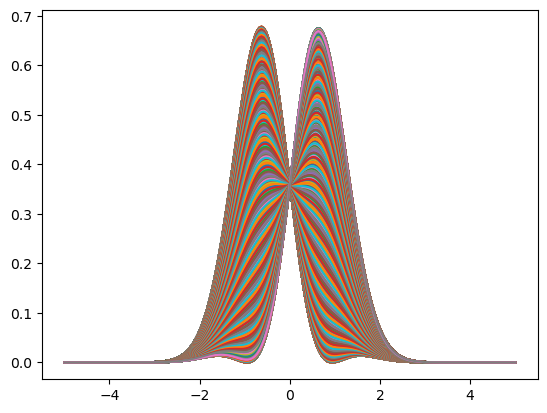

In [8]:
u1 = []
u2 = []
vetor = []
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
u1.append(random.uniform(-5, 5))
tempo = 0
xs = np.linspace(-5,5,200)
minimo = np.zeros((1, 2000)).astype(complex)
bnds = ((-0.1*np.pi, 0.1*np.pi), (-0.1*np.pi, 0.1*np.pi),
        (-0.1*np.pi, 0.1*np.pi), (-0.1*np.pi, 0.1*np.pi),
        (-0.1*np.pi, 0.1*np.pi), (-0.1*np.pi, 0.1*np.pi),
        (-0.1*np.pi, 0.1*np.pi), (-0.1*np.pi, 0.1*np.pi),
        (-0.1*np.pi, 0.1*np.pi), (-0.1*np.pi, 0.1*np.pi),
        (-0.1*np.pi, 0.1*np.pi))

while tempo < 1989:
    #print(u1)
    plt.plot(xs, np.absolute(psi[0:200, tempo])**2)
    plt.plot(xs, np.absolute(psi_g[0:200, tempo])**2)
    u2 = optimize.minimize(Objetivo, u1, args=(tempo, psi_g, psiExato), bounds = bnds, method='SLSQP')
    print(f"Iteração: {tempo+1}")
    print(f"Mínimo: {u2.x[0]}")
    #minimo[0][tempo] = (u2.x[0])
    #print("-------------")
    #print(f"{psi[0:200, tempo+1]}")
    psi_g[0:200, tempo+1] = multMatrizes(M = 200, us = u2.x[0], ps = psi_g[0:200, tempo], O = -5, L = 5, T = 20)
    #print("-------------")
    #print(f"{psi[0:200, tempo+1]}")
    tempo += 1
    u1 = []
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])
    u1.append(u2.x[0])

tempoFinal = time.time() - tempoInicial
print(tempoFinal)

In [9]:
print(psi_g[0:200,1999])
print("---------------")
print(psiExato[0:200,1999])
print("---------------")
print(psi[0:200,1999])
print("--------------")
print(psi_g[0:200,1999] - psi[0:200,1999])
print("--------------")
print(psi_g - psi)

[-3.69227736e-06+9.94341715e-07j -7.06984415e-06+2.93571425e-06j
 -1.01804611e-05+4.00089890e-06j -1.46640563e-05+4.75627697e-06j
 -2.09096709e-05+6.46172640e-06j -2.73125548e-05+8.38367484e-06j
 -3.42674502e-05+1.09906273e-05j -4.36347761e-05+1.39599280e-05j
 -5.60856055e-05+1.67581718e-05j -7.09499769e-05+2.09144109e-05j
 -8.79386022e-05+2.65333413e-05j -1.08343993e-04+3.29518774e-05j
 -1.33647438e-04+4.12370178e-05j -1.64163170e-04+5.02327844e-05j
 -2.01192665e-04+6.01863602e-05j -2.46348898e-04+7.35973248e-05j
 -3.00121546e-04+9.01029109e-05j -3.63755008e-04+1.09325364e-04j
 -4.40158777e-04+1.33247326e-04j -5.32029660e-04+1.61283953e-04j
 -6.40746923e-04+1.94445089e-04j -7.68369667e-04+2.35001391e-04j
 -9.19081904e-04+2.83073636e-04j -1.09705522e-03+3.39330887e-04j
 -1.30587486e-03+4.05704010e-04j -1.55078098e-03+4.83190539e-04j
 -1.83641086e-03+5.74461677e-04j -2.16791622e-03+6.80720421e-04j
 -2.55149334e-03+8.03027701e-04j -2.99329407e-03+9.45041430e-04j
 -3.50121551e-03+1.109423

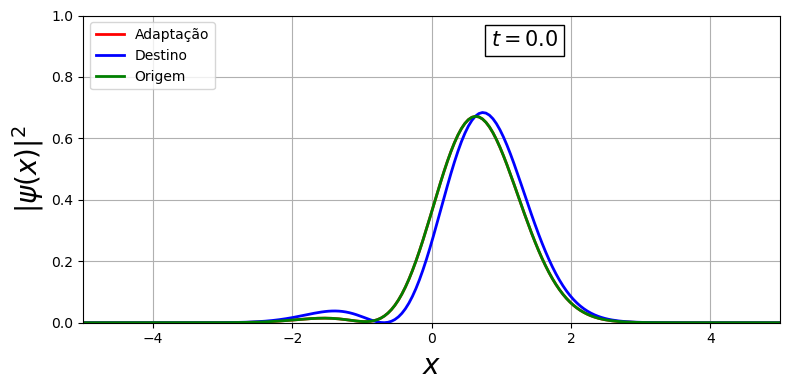

In [10]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    xs = np.linspace(-5,5,200)
    ln1.set_data(xs, np.absolute(psi_g[0:200,i-1])**2)
    ln2.set_data(xs, np.absolute(psiExato[0:200,i-1])**2)
    ln3.set_data(xs, np.absolute(psi[0:200,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Adaptação')
ln2, = plt.plot([], [], 'b-', lw=2, markersize=8, label='Destino')
ln3, = plt.plot([], [], 'g-', lw=2, markersize=8, label='Origem')
time_text = ax.text(0.85, 0.9, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(0, 1)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=2000, interval=2000)
ani.save('200x200_bounds.gif',writer='pillow',fps=20,dpi=100)